In [22]:
#import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import itertools
import sympy as sym

In [3]:
#Read in data frame 
dat = pd.read_csv('thermal_decay.csv')

In [4]:
#Reformat data frame by combining date and time and removing unusually large temperature values.
temp = np.array(dat['Readings_F'], dtype = float)
dat['Temp_F'] = temp
dat = dat[dat['Temp_F']<85]
dat['DateTime'] = pd.to_datetime(dat.Date + ' ' + dat.Time)

In [5]:
temp = np.array(dat[['DateTime', 'Temp_F']])

In [6]:
#Show array of timestamps and inside temperature data.
temp

array([[Timestamp('2018-09-24 15:11:03'), 75.3],
       [Timestamp('2018-09-24 15:21:03'), 73.4],
       [Timestamp('2018-09-24 15:31:03'), 72.9],
       ...,
       [Timestamp('2018-10-18 16:51:03'), 72.9],
       [Timestamp('2018-10-18 17:01:03'), 72.9],
       [Timestamp('2018-10-18 17:11:03'), 72.8]], dtype=object)

In [7]:
#Parse lists of decay events. 
#General idea: if a temperature at time t is below temperature at t-1, add to pre-existing list of temperatures. 
# If the temperature is at a local maximum, start a decay event. 
# If the temperature is at a local minimum, end the decay event. 
# This method may not create single decays for what we may think of as a decay event: i.e. it will create 2 events for one night if the temperature increases by 0.1 degree. 
# This method also captures any decay, not just exponencial decays.
# Details on suggestions to fix this issue are outlined in the Spring 2020 writeup. 

temps = []
temps.append(list())
counter = 0
vector_counter = 0
for i in range(len(temp)):
    current = temp[i]
    if i > 0: 
        prev= temp[i-1]
    else: prev = current
    if i < len(temp)-1:
        nex = temp[i + 1]
    else: nex = current
    if len(temps[vector_counter]) != 0:
        if current[1] <= prev[1]:
            temps[vector_counter].append(current)
        if current[1] > prev[1]:
            vector_counter = vector_counter + 1
            temps.append(list())
    elif current[1] >= prev[1] and current[1] > nex[1]:
        temps[vector_counter].append(current)

In [8]:
#Only analyze runs > 2.5 hours. 
runs = []
for i in temps:
    if len(i) > 15:
        runs.append(i)

In [9]:
first = runs[1] #First night-time run - use for rest of analysis. 

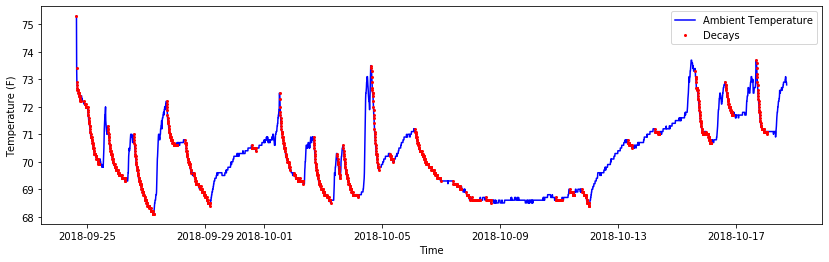

In [95]:
#Visualize decay runs that algorithm detected. 
merged = list(itertools.chain(*runs))
merged = pd.DataFrame(merged, columns = ['DateTime', 'Temperature'])
plt.figure(figsize = (14,4))
plt.plot(dat.DateTime, dat.Temp_F, 'b', label = 'Ambient Temperature')
plt.plot(merged.DateTime, merged.Temperature, 'ro', markersize=2, label = 'Decays')
plt.xlabel('Time')
plt.ylabel('Temperature (F)')
plt.legend()

In [16]:
#Turn first decay event into dataframe 
first = pd.DataFrame(first, columns = ['DateTime', 'Temperature'])
df_inside = first[['DateTime', 'Temperature']]

In [17]:
#Read in external weather data. 
#We only have weather data from this decay event because it is only accessible per hour in 24 hour interval csv files.
#In fall 2020, we will collect localized outside weather data with logtags, which will get rid of this issue. 
weather = pd.read_csv("9-24-18-ithaca_weather.csv")
weather['DateTime'] = pd.to_datetime(weather.Day + ' ' + weather.Time)
df_weather = weather[['DateTime', 'Temperature']]

In [18]:
#Join inside and outside temperatures on the nearest hour. 
df = pd.merge_asof(df_inside, df_weather, on = 'DateTime', direction = 'nearest')
df.columns = ['DateTime', 'Temp_In', 'Temp_Out']
df['Temp_Diff'] = df.Temp_In - df.Temp_Out
index = range(0,len(df))
df['Index'] = index
df.head() 

,DateTime,Temp_In,Temp_Out,Temp_Diff,Index
0,2018-09-24 21:41:03,72.2,57,15.2,0
1,2018-09-24 21:51:03,72.1,57,15.1,1
2,2018-09-24 22:01:03,72.1,57,15.1,2
3,2018-09-24 22:11:03,72.1,57,15.1,3
4,2018-09-24 22:21:03,72.1,57,15.1,4


/Users/Callie/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


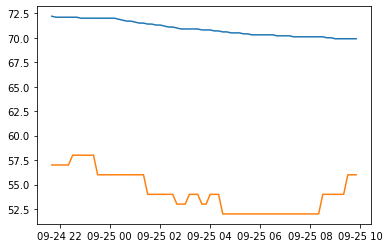

In [19]:
#Show outside vs. inside temperatures. 
plt.plot(df.DateTime, df.Temp_In)
plt.plot(df.DateTime, df.Temp_Out)

In [21]:
#For proof of concept, only look at middle of decay.
reduced = df[(df['Index']>16) &  (df['Index']<65)]
reduced_2 = df.loc[(df['Index']>16) &  (df['Index']<65)]
reduced_2.head()

,DateTime,Temp_In,Temp_Out,Temp_Diff,Index
17,2018-09-25 00:31:03,71.8,56,15.8,17
18,2018-09-25 00:41:03,71.7,56,15.7,18
19,2018-09-25 00:51:03,71.7,56,15.7,19
20,2018-09-25 01:01:03,71.6,56,15.6,20
21,2018-09-25 01:11:03,71.5,56,15.5,21


In [23]:
#Fit exponential decay curve to inside data. 
def func(x, a, b, c):
    return a*np.exp(-b*x) +c
popt, pcov = curve_fit(func, reduced.Index, reduced.Temp_In, maxfev = 10000, p0 = [80,0.5,60])
popt

array([3.88360734e+00, 3.04307804e-02, 6.94872023e+01])

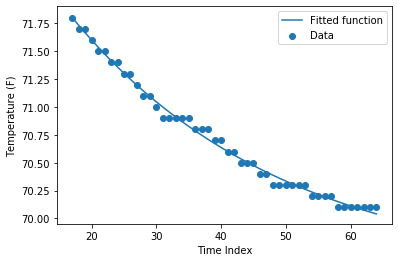

In [94]:
#Show curve's fit.
plt.scatter(reduced.Index, reduced.Temp_In, label='Data')
plt.plot(reduced.Index, func(reduced.Index, popt[0], popt[1], popt[2]),
         label='Fitted function')

plt.legend(loc='best')
plt.xlabel('Time Index')
plt.ylabel('Temperature (F)')
plt.show()

In [24]:
#Take derivitive of fitted line. 
x = sym.Symbol('x')
deriv = sym.diff(popt[0]**(-popt[1]*x) + popt[2])
deriv

-0.0412874008937131*3.88360733651516**(-0.0304307803512464*x)

In [29]:
def der_func(x):
    #return deriv
    return -0.0412874008937131*3.88360733651516**(-0.0304307803512464*x)
#To scale, put deriv into der_func. without copy/pasting function. (Would not work as return deriv)
#Test
der_func(20)

-0.01808005455614346

In [30]:
#Find temp decay derivitive at each time step.
point_derivs = []
for i in reduced.Index:
    point_derivs.append(der_func(i))

In [31]:
reduced.reset_index

<bound method DataFrame.reset_index of               DateTime  Temp_In  Temp_Out  Temp_Diff  Index
17 2018-09-25 00:31:03     71.8        56       15.8     17
18 2018-09-25 00:41:03     71.7        56       15.7     18
19 2018-09-25 00:51:03     71.7        56       15.7     19
20 2018-09-25 01:01:03     71.6        56       15.6     20
21 2018-09-25 01:11:03     71.5        56       15.5     21
22 2018-09-25 01:21:03     71.5        56       15.5     22
23 2018-09-25 01:31:03     71.4        54       17.4     23
24 2018-09-25 01:41:03     71.4        54       17.4     24
25 2018-09-25 01:51:03     71.3        54       17.3     25
26 2018-09-25 02:01:03     71.3        54       17.3     26
27 2018-09-25 02:11:03     71.2        54       17.2     27
28 2018-09-25 02:21:03     71.1        54       17.1     28
29 2018-09-25 02:31:03     71.1        54       17.1     29
30 2018-09-25 02:41:03     71.0        53       18.0     30
31 2018-09-25 02:51:03     70.9        53       17.9     31
3

In [32]:
#Add slopes to dataset.
reduced['Temp_In_Slope'] = point_derivs
reduced

/Users/Callie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,DateTime,Temp_In,Temp_Out,Temp_Diff,Index,Temp_In_Slope
17,2018-09-25 00:31:03,71.8,56,15.8,17,-0.020464
18,2018-09-25 00:41:03,71.7,56,15.7,18,-0.019636
19,2018-09-25 00:51:03,71.7,56,15.7,19,-0.018842
20,2018-09-25 01:01:03,71.6,56,15.6,20,-0.018080
21,2018-09-25 01:11:03,71.5,56,15.5,21,-0.017349
22,2018-09-25 01:21:03,71.5,56,15.5,22,-0.016647
23,2018-09-25 01:31:03,71.4,54,17.4,23,-0.015974
24,2018-09-25 01:41:03,71.4,54,17.4,24,-0.015328
25,2018-09-25 01:51:03,71.3,54,17.3,25,-0.014708
26,2018-09-25 02:01:03,71.3,54,17.3,26,-0.014113


In [33]:
#Find Thermal Mass * Thermal Resistance at each timestep.
reduced['MCpR'] = -reduced.Temp_Diff/reduced.Temp_In_Slope

/Users/Callie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
reduced

,DateTime,Temp_In,Temp_Out,Temp_Diff,Index,Temp_In_Slope,MCpR
17,2018-09-25 00:31:03,71.8,56,15.8,17,-0.020464,772.084225
18,2018-09-25 00:41:03,71.7,56,15.7,18,-0.019636,799.536206
19,2018-09-25 00:51:03,71.7,56,15.7,19,-0.018842,833.237919
20,2018-09-25 01:01:03,71.6,56,15.6,20,-0.018080,862.829255
21,2018-09-25 01:11:03,71.5,56,15.5,21,-0.017349,893.434774
22,2018-09-25 01:21:03,71.5,56,15.5,22,-0.016647,931.094459
23,2018-09-25 01:31:03,71.4,54,17.4,23,-0.015974,1089.286654
24,2018-09-25 01:41:03,71.4,54,17.4,24,-0.015328,1135.201806
25,2018-09-25 01:51:03,71.3,54,17.3,25,-0.014708,1176.253201
26,2018-09-25 02:01:03,71.3,54,17.3,26,-0.014113,1225.834130


In [ ]:
#MCpR likely increasing because of inaccurate outside temperature data. 
#Next steps, complete for all decay events and find average MCpR for home. 